Find the suitable values for the hyperparameters(epochs, batch size, lstm units, dropout) of the LSTM model which give the best results 

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
# Cleaning the data
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

timestamp_s = date_time.map(datetime.datetime.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))



13574144/13568290 [==============================] - 0s 0us/step


In [37]:
def split_data(df):
  column_indices = {name: i for i, name in enumerate(df.columns)}
  n = len(df)
  train_df = df[0:int(n*0.7)]
  val_df = df[int(n*0.7):int(n*0.9)]
  test_df = df[int(n*0.9):]
  return train_df, val_df, test_df

def add_noise(test_df, mu, sigma):
  # generate a random number from a normal distribution
  # creating a noise with the same dimension as the dataset
  noise = np.random.normal(mu, sigma, test_df.shape)
  # adding the noise to the dataset
  noisy_test_df = test_df + noise
  return noisy_test_df

def normalise_data(train_df, val_df, test_df, noisy_test_df):
  num_features = df.shape[1]
  train_mean = train_df.mean()
  train_std = train_df.std()

  train_df = (train_df - train_mean) / train_std
  val_df = (val_df - train_mean) / train_std
  test_df = (test_df - train_mean) / train_std
  noisy_test_df = (noisy_test_df - train_mean) / train_std
  return train_df, val_df, test_df, noisy_test_df

def train_ss_so_model(wide_window):
  num_features = wide_window.train_df.shape[1]
  ss_so_model = tf.keras.models.Sequential([
      # Shape [batch, time, features] => [batch, time, lstm_units]
      tf.keras.layers.LSTM(32, return_sequences=True),
      # Shape => [batch, time, features]
      tf.keras.layers.Dense(units=1)
  ])
  print('Input shape:', wide_window.example[0].shape)
  print('Output shape:', ss_so_model(wide_window.example[0]).shape)
  ss_so_model_history = compile_and_fit(ss_so_model, wide_window)
  return ss_so_model, ss_so_model_history

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32)
  ds = ds.map(self.split_window)
  return ds
    
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def noisy_test(self):
  return self.make_dataset(self.noisy_test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result


def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

# Split dataset into 70%, 20% and 10%
train_df, val_df, test_df = split_data(df)
mu, sigma = 0, 0
noisy_test_df = add_noise(test_df, mu, sigma)
# Normalise the dataset
train_df, val_df, test_df, noisy_test_df = normalise_data(train_df, val_df, test_df, noisy_test_df)

# Finding best epoch

In [8]:
MAX_EPOCHS = 20
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df, 
               noisy_test_df=noisy_test_df, label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.noisy_test_df = noisy_test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


WindowGenerator.split_window = split_window
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.noisy_test = noisy_test
WindowGenerator.example = example

# Perdict only one target variable (Temperature)
ss_so_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

# Single step single output model
ss_so_model, history = train_ss_so_model(ss_so_window)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)
Epoch 1/20
1533/1533 [==============================] - 21s 12ms/step - loss: 0.0786 - mean_absolute_error: 0.1532 - val_loss: 0.0066 - val_mean_absolute_error: 0.0571
Epoch 2/20
1533/1533 [==============================] - 17s 11ms/step - loss: 0.0066 - mean_absolute_error: 0.0569 - val_loss: 0.0060 - val_mean_absolute_error: 0.0537
Epoch 3/20
1533/1533 [==============================] - 18s 12ms/step - loss: 0.0061 - mean_absolute_error: 0.0541 - val_loss: 0.0058 - val_mean_absolute_error: 0.0531
Epoch 4/20
1533/1533 [==============================] - 18s 12ms/step - loss: 0.0059 - mean_absolute_error: 0.0529 - val_loss: 0.0057 - val_mean_absolute_error: 0.0522
Epoch 5/20
1533/1533 [==============================] - 17s 11ms/step - loss: 0.0057 - mean_absolute_error: 0.0522 - val_loss: 0.0056 - val_mean_absolute_error: 0.0515
Epoch 6/20
1533/1533 [==============================] - 18s 12ms/step - loss: 0.0056 - mean_absolute_error: 

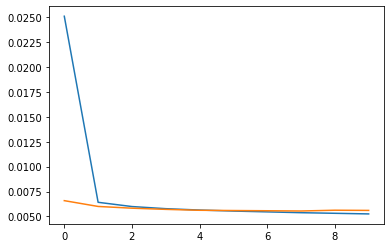

In [24]:
xc = range(len(history.history['loss']))
plt.figure()
plt.plot(xc, history.history['loss'])
plt.plot(xc, history.history['val_loss'])


Since the validation loss is not improving much, 20 epochs should be more than enough for training. It might start overfitting if we increase the epochs
# Find batch size

In [29]:
def batch_size(batch_size):
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=batch_size)
    ds = ds.map(self.split_window)
    return ds

  MAX_EPOCHS = 20
  class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df, 
                noisy_test_df=noisy_test_df, label_columns=None):
      # Store the raw data.
      self.train_df = train_df
      self.val_df = val_df
      self.test_df = test_df
      self.noisy_test_df = noisy_test_df

      # Work out the label column indices.
      self.label_columns = label_columns
      if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
      self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

      # Work out the window parameters.
      self.input_width = input_width
      self.label_width = label_width
      self.shift = shift

      self.total_window_size = input_width + shift

      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_size)[self.input_slice]

      self.label_start = self.total_window_size - self.label_width
      self.labels_slice = slice(self.label_start, None)
      self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
      return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])


  WindowGenerator.split_window = split_window
  WindowGenerator.make_dataset = make_dataset
  WindowGenerator.train = train
  WindowGenerator.val = val
  WindowGenerator.test = test
  WindowGenerator.noisy_test = noisy_test
  WindowGenerator.example = example

  # Perdict only one target variable (Temperature)
  ss_so_window = WindowGenerator(
      input_width=24, label_width=24, shift=1,
      label_columns=['T (degC)'])

  # Single step single output model
  ss_so_model, history = train_ss_so_model(ss_so_window)

  xc = range(len(history.history['loss']))
  plt.figure()
  plt.plot(xc, history.history['loss'])
  plt.plot(xc, history.history['val_loss'])


Input shape: (1, 24, 19)
Output shape: (1, 24, 1)
Epoch 1/20
49039/49039 [==============================] - 365s 7ms/step - loss: 0.0148 - mean_absolute_error: 0.0717 - val_loss: 0.0056 - val_mean_absolute_error: 0.0515
Epoch 2/20
49039/49039 [==============================] - 364s 7ms/step - loss: 0.0057 - mean_absolute_error: 0.0524 - val_loss: 0.0056 - val_mean_absolute_error: 0.0512
Epoch 3/20
49039/49039 [==============================] - 363s 7ms/step - loss: 0.0053 - mean_absolute_error: 0.0510 - val_loss: 0.0057 - val_mean_absolute_error: 0.0521
Epoch 4/20
49039/49039 [==============================] - 364s 7ms/step - loss: 0.0051 - mean_absolute_error: 0.0501 - val_loss: 0.0058 - val_mean_absolute_error: 0.0525


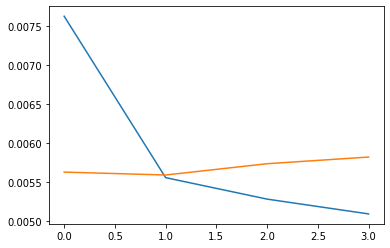

In [31]:
batch_size(1)

Input shape: (4, 24, 19)
Output shape: (4, 24, 1)
Epoch 1/20
12260/12260 [==============================] - 109s 9ms/step - loss: 0.0267 - mean_absolute_error: 0.0883 - val_loss: 0.0057 - val_mean_absolute_error: 0.0520
Epoch 2/20
12260/12260 [==============================] - 106s 9ms/step - loss: 0.0058 - mean_absolute_error: 0.0529 - val_loss: 0.0056 - val_mean_absolute_error: 0.0512
Epoch 3/20
12260/12260 [==============================] - 106s 9ms/step - loss: 0.0055 - mean_absolute_error: 0.0512 - val_loss: 0.0055 - val_mean_absolute_error: 0.0509
Epoch 4/20
12260/12260 [==============================] - 106s 9ms/step - loss: 0.0053 - mean_absolute_error: 0.0504 - val_loss: 0.0055 - val_mean_absolute_error: 0.0509
Epoch 5/20
12260/12260 [==============================] - 108s 9ms/step - loss: 0.0051 - mean_absolute_error: 0.0499 - val_loss: 0.0056 - val_mean_absolute_error: 0.0518


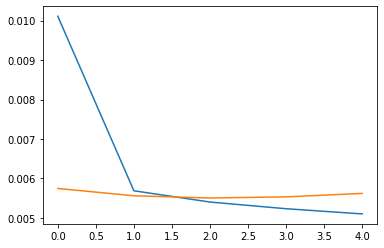

In [30]:
batch_size(4)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)
Epoch 1/20
1533/1533 [==============================] - 21s 12ms/step - loss: 0.0760 - mean_absolute_error: 0.1515 - val_loss: 0.0066 - val_mean_absolute_error: 0.0578
Epoch 2/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0066 - mean_absolute_error: 0.0569 - val_loss: 0.0060 - val_mean_absolute_error: 0.0540
Epoch 3/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0060 - mean_absolute_error: 0.0538 - val_loss: 0.0057 - val_mean_absolute_error: 0.0521
Epoch 4/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0058 - mean_absolute_error: 0.0525 - val_loss: 0.0058 - val_mean_absolute_error: 0.0528
Epoch 5/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0056 - mean_absolute_error: 0.0518 - val_loss: 0.0057 - val_mean_absolute_error: 0.0521
Epoch 6/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0055 - mean_absolute_error: 

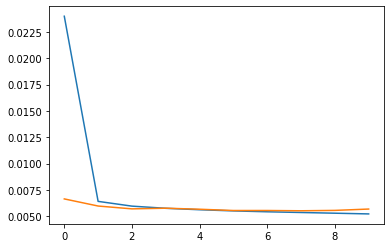

In [34]:
batch_size(32)

Batch size of 1 and 4 takes too long to train(more than 100s) for single epoch. With batch size 32 we get the same result with faster execution time
# Find LSTM Units

In [38]:
def change_units(units):
  def train_ss_so_model(wide_window, unit_value):
    num_features = wide_window.train_df.shape[1]
    ss_so_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(unit_value, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])
    print('Input shape:', wide_window.example[0].shape)
    print('Output shape:', ss_so_model(wide_window.example[0]).shape)
    ss_so_model_history = compile_and_fit(ss_so_model, wide_window)
    return ss_so_model, ss_so_model_history

  MAX_EPOCHS = 20
  class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df, 
                noisy_test_df=noisy_test_df, label_columns=None):
      # Store the raw data.
      self.train_df = train_df
      self.val_df = val_df
      self.test_df = test_df
      self.noisy_test_df = noisy_test_df

      # Work out the label column indices.
      self.label_columns = label_columns
      if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
      self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

      # Work out the window parameters.
      self.input_width = input_width
      self.label_width = label_width
      self.shift = shift

      self.total_window_size = input_width + shift

      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_size)[self.input_slice]

      self.label_start = self.total_window_size - self.label_width
      self.labels_slice = slice(self.label_start, None)
      self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
      return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])


  WindowGenerator.split_window = split_window
  WindowGenerator.make_dataset = make_dataset
  WindowGenerator.train = train
  WindowGenerator.val = val
  WindowGenerator.test = test
  WindowGenerator.noisy_test = noisy_test
  WindowGenerator.example = example

  # Perdict only one target variable (Temperature)
  ss_so_window = WindowGenerator(
      input_width=24, label_width=24, shift=1,
      label_columns=['T (degC)'])

  # Single step single output model
  ss_so_model, history = train_ss_so_model(ss_so_window, units)

  xc = range(len(history.history['loss']))
  plt.figure()
  plt.plot(xc, history.history['loss'])
  plt.plot(xc, history.history['val_loss'])

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)
Epoch 1/20
1533/1533 [==============================] - 20s 11ms/step - loss: 0.5259 - mean_absolute_error: 0.5389 - val_loss: 0.0416 - val_mean_absolute_error: 0.1237
Epoch 2/20
1533/1533 [==============================] - 18s 11ms/step - loss: 0.0408 - mean_absolute_error: 0.1193 - val_loss: 0.0149 - val_mean_absolute_error: 0.0756
Epoch 3/20
1533/1533 [==============================] - 17s 11ms/step - loss: 0.0160 - mean_absolute_error: 0.0776 - val_loss: 0.0108 - val_mean_absolute_error: 0.0685
Epoch 4/20
1533/1533 [==============================] - 17s 11ms/step - loss: 0.0113 - mean_absolute_error: 0.0702 - val_loss: 0.0092 - val_mean_absolute_error: 0.0660
Epoch 5/20
1533/1533 [==============================] - 17s 11ms/step - loss: 0.0095 - mean_absolute_error: 0.0669 - val_loss: 0.0084 - val_mean_absolute_error: 0.0645
Epoch 6/20
1533/1533 [==============================] - 17s 11ms/step - loss: 0.0086 - mean_absolute_error: 

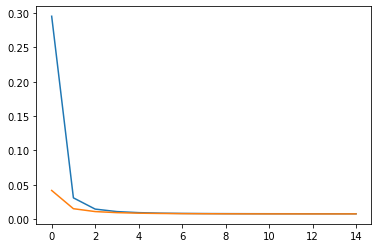

In [39]:
change_units(1)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)
Epoch 1/20
1533/1533 [==============================] - 21s 12ms/step - loss: 0.1247 - mean_absolute_error: 0.2051 - val_loss: 0.0087 - val_mean_absolute_error: 0.0675
Epoch 2/20
1533/1533 [==============================] - 18s 12ms/step - loss: 0.0081 - mean_absolute_error: 0.0641 - val_loss: 0.0065 - val_mean_absolute_error: 0.0567
Epoch 3/20
1533/1533 [==============================] - 18s 12ms/step - loss: 0.0066 - mean_absolute_error: 0.0569 - val_loss: 0.0060 - val_mean_absolute_error: 0.0539
Epoch 4/20
1533/1533 [==============================] - 18s 12ms/step - loss: 0.0062 - mean_absolute_error: 0.0547 - val_loss: 0.0058 - val_mean_absolute_error: 0.0529
Epoch 5/20
1533/1533 [==============================] - 18s 12ms/step - loss: 0.0060 - mean_absolute_error: 0.0537 - val_loss: 0.0058 - val_mean_absolute_error: 0.0525
Epoch 6/20
1533/1533 [==============================] - 18s 12ms/step - loss: 0.0059 - mean_absolute_error: 

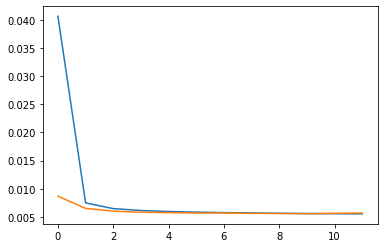

In [40]:
change_units(16)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)
Epoch 1/20
1533/1533 [==============================] - 21s 12ms/step - loss: 0.0447 - mean_absolute_error: 0.1255 - val_loss: 0.0063 - val_mean_absolute_error: 0.0556
Epoch 2/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0063 - mean_absolute_error: 0.0554 - val_loss: 0.0059 - val_mean_absolute_error: 0.0531
Epoch 3/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0059 - mean_absolute_error: 0.0531 - val_loss: 0.0057 - val_mean_absolute_error: 0.0522
Epoch 4/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0057 - mean_absolute_error: 0.0521 - val_loss: 0.0056 - val_mean_absolute_error: 0.0513
Epoch 5/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0056 - mean_absolute_error: 0.0514 - val_loss: 0.0056 - val_mean_absolute_error: 0.0513
Epoch 6/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0055 - mean_absolute_error: 

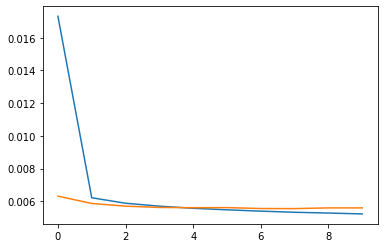

In [41]:
change_units(32)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)
Epoch 1/20
1533/1533 [==============================] - 23s 13ms/step - loss: 0.0585 - mean_absolute_error: 0.1296 - val_loss: 0.0063 - val_mean_absolute_error: 0.0558
Epoch 2/20
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0062 - mean_absolute_error: 0.0548 - val_loss: 0.0058 - val_mean_absolute_error: 0.0527
Epoch 3/20
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0058 - mean_absolute_error: 0.0528 - val_loss: 0.0056 - val_mean_absolute_error: 0.0520
Epoch 4/20
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0056 - mean_absolute_error: 0.0519 - val_loss: 0.0057 - val_mean_absolute_error: 0.0524
Epoch 5/20
1533/1533 [==============================] - 20s 13ms/step - loss: 0.0054 - mean_absolute_error: 0.0509 - val_loss: 0.0058 - val_mean_absolute_error: 0.0534


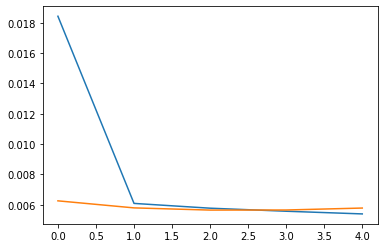

In [42]:
change_units(64)

For 32 units we get the best performance. Increasing further does not show any improvement

# Explore Dropout

In [46]:
def change_dropout(dv):
  def train_ss_so_model(wide_window, dv):
    num_features = wide_window.train_df.shape[1]
    ss_so_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=True, dropout=dv),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])
    print('Input shape:', wide_window.example[0].shape)
    print('Output shape:', ss_so_model(wide_window.example[0]).shape)
    ss_so_model_history = compile_and_fit(ss_so_model, wide_window)
    return ss_so_model, ss_so_model_history

  MAX_EPOCHS = 20
  class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df=train_df, val_df=val_df, test_df=test_df, 
                noisy_test_df=noisy_test_df, label_columns=None):
      # Store the raw data.
      self.train_df = train_df
      self.val_df = val_df
      self.test_df = test_df
      self.noisy_test_df = noisy_test_df

      # Work out the label column indices.
      self.label_columns = label_columns
      if label_columns is not None:
        self.label_columns_indices = {name: i for i, name in
                                      enumerate(label_columns)}
      self.column_indices = {name: i for i, name in
                            enumerate(train_df.columns)}

      # Work out the window parameters.
      self.input_width = input_width
      self.label_width = label_width
      self.shift = shift

      self.total_window_size = input_width + shift

      self.input_slice = slice(0, input_width)
      self.input_indices = np.arange(self.total_window_size)[self.input_slice]

      self.label_start = self.total_window_size - self.label_width
      self.labels_slice = slice(self.label_start, None)
      self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
      return '\n'.join([
          f'Total window size: {self.total_window_size}',
          f'Input indices: {self.input_indices}',
          f'Label indices: {self.label_indices}',
          f'Label column name(s): {self.label_columns}'])


  WindowGenerator.split_window = split_window
  WindowGenerator.make_dataset = make_dataset
  WindowGenerator.train = train
  WindowGenerator.val = val
  WindowGenerator.test = test
  WindowGenerator.noisy_test = noisy_test
  WindowGenerator.example = example

  # Perdict only one target variable (Temperature)
  ss_so_window = WindowGenerator(
      input_width=24, label_width=24, shift=1,
      label_columns=['T (degC)'])

  # Single step single output model
  ss_so_model, history = train_ss_so_model(ss_so_window, dv)

  xc = range(len(history.history['loss']))
  plt.figure()
  plt.plot(xc, history.history['loss'])
  plt.plot(xc, history.history['val_loss'])

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)
Epoch 1/20
1533/1533 [==============================] - 21s 12ms/step - loss: 0.0331 - mean_absolute_error: 0.1130 - val_loss: 0.0067 - val_mean_absolute_error: 0.0575
Epoch 2/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0079 - mean_absolute_error: 0.0622 - val_loss: 0.0062 - val_mean_absolute_error: 0.0548
Epoch 3/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0073 - mean_absolute_error: 0.0597 - val_loss: 0.0060 - val_mean_absolute_error: 0.0546
Epoch 4/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0069 - mean_absolute_error: 0.0583 - val_loss: 0.0059 - val_mean_absolute_error: 0.0533
Epoch 5/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0066 - mean_absolute_error: 0.0572 - val_loss: 0.0060 - val_mean_absolute_error: 0.0548
Epoch 6/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0063 - mean_absolute_error: 

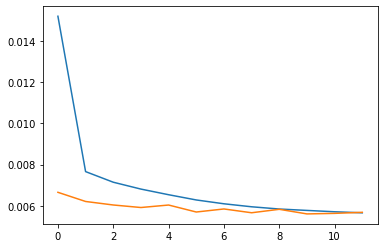

In [51]:
change_dropout(0.01)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)
Epoch 1/20
1533/1533 [==============================] - 22s 13ms/step - loss: 0.0976 - mean_absolute_error: 0.1795 - val_loss: 0.0088 - val_mean_absolute_error: 0.0689
Epoch 2/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0145 - mean_absolute_error: 0.0886 - val_loss: 0.0081 - val_mean_absolute_error: 0.0654
Epoch 3/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0121 - mean_absolute_error: 0.0805 - val_loss: 0.0082 - val_mean_absolute_error: 0.0663
Epoch 4/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0101 - mean_absolute_error: 0.0731 - val_loss: 0.0086 - val_mean_absolute_error: 0.0688


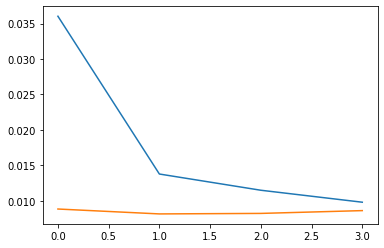

In [50]:
change_dropout(0.1)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)
Epoch 1/20
1533/1533 [==============================] - 21s 12ms/step - loss: 0.1032 - mean_absolute_error: 0.1989 - val_loss: 0.0120 - val_mean_absolute_error: 0.0805
Epoch 2/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0196 - mean_absolute_error: 0.1037 - val_loss: 0.0124 - val_mean_absolute_error: 0.0810
Epoch 3/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0155 - mean_absolute_error: 0.0922 - val_loss: 0.0170 - val_mean_absolute_error: 0.0968


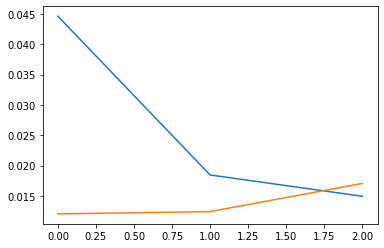

In [47]:
change_dropout(0.2)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)
Epoch 1/20
1533/1533 [==============================] - 21s 12ms/step - loss: 0.0864 - mean_absolute_error: 0.1993 - val_loss: 0.0207 - val_mean_absolute_error: 0.1047
Epoch 2/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0274 - mean_absolute_error: 0.1232 - val_loss: 0.0410 - val_mean_absolute_error: 0.1415
Epoch 3/20
1533/1533 [==============================] - 19s 13ms/step - loss: 0.0211 - mean_absolute_error: 0.1078 - val_loss: 0.0568 - val_mean_absolute_error: 0.1723


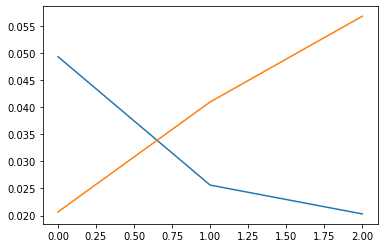

In [48]:
change_dropout(0.4)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)
Epoch 1/20
1533/1533 [==============================] - 22s 13ms/step - loss: 0.1221 - mean_absolute_error: 0.2419 - val_loss: 0.0602 - val_mean_absolute_error: 0.1689
Epoch 2/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0409 - mean_absolute_error: 0.1494 - val_loss: 0.1327 - val_mean_absolute_error: 0.2617
Epoch 3/20
1533/1533 [==============================] - 19s 12ms/step - loss: 0.0305 - mean_absolute_error: 0.1281 - val_loss: 0.2161 - val_mean_absolute_error: 0.3501


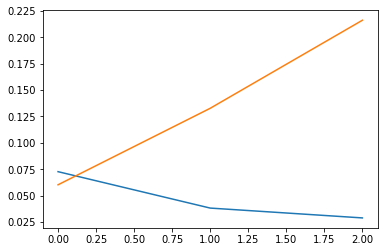

In [49]:
change_dropout(0.6)

Adding dropout values does not seem to improve the performance of our model. Using a very low dropout value gives a result close to the one without using an dropout.

**We get the best result when we use train the model using batch size of 32 with 32 LSTM units for 20 epochs without using any dropout**

# References
1. https://machinelearningmastery.com/tune-lstm-hyperparameters-keras-time-series-forecasting/
2. https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
